In [6]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
from operator import itemgetter
import datetime
import pandas as pd
from collections import defaultdict
from itertools import combinations
pd.options.display.max_rows = 10

In [7]:
output_code = "00_02_05"

### Create the network where authors come in every quarter

In [8]:
def strf_date_if_not_na(x, strftime='%Y-%m'):
    if pd.isna(x):
        return np.nan
    else:
        return x.strftime('%Y-%m')

In [9]:
article_authors = pd.read_csv("../inputs/untracked/article-authors_04-27.csv",sep = "|")

In [12]:
def get_month_from_a_string_datetime(s):
    return datetime.datetime.strptime(s,"%Y-%m-%d").month

In [11]:
article_authors_filtered = article_authors[article_authors['converted_datetime'].notnull()]
article_authors_filtered = article_authors_filtered[article_authors_filtered["cord_uid"] != "1vimqhdp"]

In [13]:
article_authors_filtered["year_month"] = article_authors_filtered["converted_datetime"].apply(lambda x: str(pd.Timestamp(x).year)+"-%02d"%(get_month_from_a_string_datetime(x)))

In [14]:
earliest_publication = article_authors_filtered[['author_id', 'converted_datetime']].groupby('author_id')\
            .min()[['converted_datetime']].reset_index()

In [15]:
earliest_publication["year_month"] = earliest_publication["converted_datetime"].apply(lambda x: str(pd.Timestamp(x).year)+"-%02d"%(get_month_from_a_string_datetime(x)))

In [16]:
## We create a dictionary where the key is the year_quarter and
## value is the list of nodes that first published in that quarter
# https://stackoverflow.com/questions/29876184/groupby-results-to-dictionary-of-lists
dict_newcomer_nodes_by_year_quarter = earliest_publication.groupby("year_month")["author_id"].apply(set).to_dict()

In [17]:

## Portion of nodes in the connected giant components
dict_portion_new_nodes_in_gcc_by_quarter = dict()

## Get unique weeks first. It is possible that the week information might
## be noisy because automatically a date with no month or day information is
## assigned with first day of the year

## We will keep adding nodes into the network week by week
G = nx.Graph()


for current_quarter in sorted(article_authors_filtered["year_month"].unique()):
    ## Current new papers that are published in this quarter
    df_current_quarter = article_authors_filtered[article_authors_filtered["year_month"]==current_quarter]
    ## dictionary of coauthor set who have written the paper together
    dict_coauthor_sets = df_current_quarter.groupby("cord_uid")["author_id"].apply(set).to_dict()
    ## Creating an edgelist with weight for each co-author tuple
    edgelist_with_weight = defaultdict(int)
    for coauthor_set in dict_coauthor_sets.values():
        for edge_tuple in combinations(sorted(coauthor_set),2):
                edgelist_with_weight[edge_tuple] += 1

    for edge_tuple,weight in edgelist_with_weight.items():
        e1,e2 = edge_tuple
        if G.has_edge(e1,e2):
            # we added this one before, just increase the weight by one
            G[e1][e2]['weight'] += weight
        else:
            # new edge. add with weight=1
            G.add_edge(e1, e2, weight=1)



    ## Getting the current giant connected compnent nodes
    gcc_nodes = sorted(nx.connected_components(G),key = len, reverse=True)[0]
    ## Now we will compare what portion of newcomer nodes are in the giant connceted
    ## component
    
    if current_quarter in dict_newcomer_nodes_by_year_quarter:
        nodes_current_quarter = dict_newcomer_nodes_by_year_quarter[current_quarter]
        dict_portion_new_nodes_in_gcc_by_quarter[current_quarter] = len([node for node in nodes_current_quarter if node in gcc_nodes])/len(nodes_current_quarter)
    else:
        ## There were no new nodes that came in this quarter
        pass

### Now plotting the portion of newcomers in GCC in each month of years

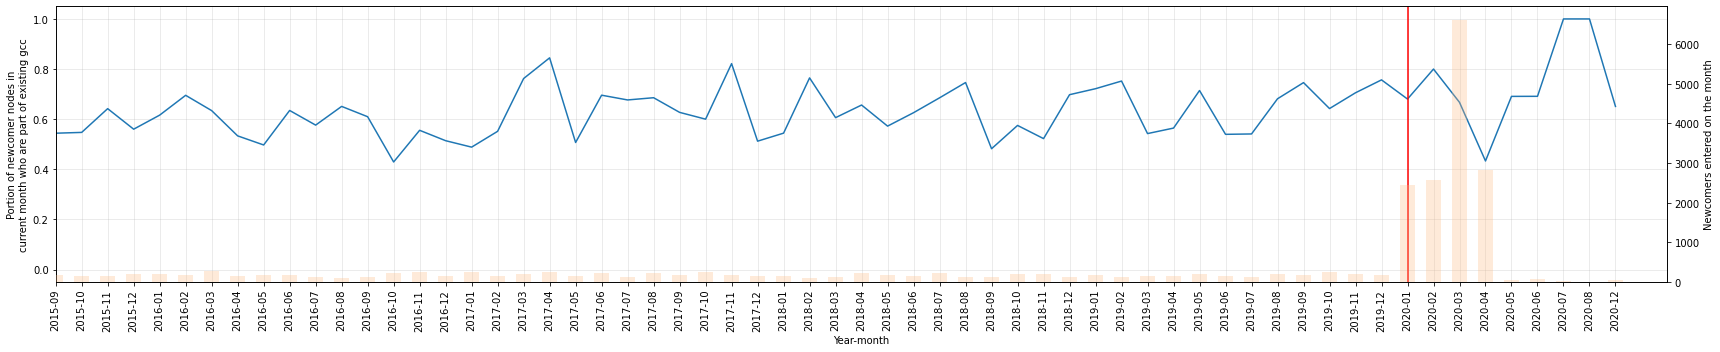

In [18]:
fig,ax = plt.subplots(figsize = (24,5))
keys,values = zip(*sorted(dict_portion_new_nodes_in_gcc_by_quarter.items()))
ax.plot(keys,values)
ax_newcomer_count = ax.twinx()
timewindows, newcomer_counts = zip(*sorted({k:len(v) for k,v in dict_newcomer_nodes_by_year_quarter.items()}.items()))
ax_newcomer_count.bar(timewindows,newcomer_counts ,width=0.6, alpha=0.3, zorder = 5, color = "#fdbb84")
#ax_newcomer_count.set_yscale('log')
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys,rotation=90)
## Indicating the First quarter of 2020
ax.axvline(keys.index("2020-01"), color = "red")
ax.set_xlim(keys.index("2020-01")-52,len(keys)+1)
ax.grid(alpha = 0.3)
#fig.tight_layout()
ax.set_xlabel("Year-month")
ax.set_ylabel("Portion of newcomer nodes in\ncurrent month who are part of existing gcc")
ax_newcomer_count.set_ylabel("Newcomers entered on the month")
plt.tight_layout()
plt.savefig("../outputs/figures/%s_monthly_portion_of_newcomers_part_of_gcc.png" %output_code, dpi = 150)
plt.show()